# Model Idenitfiability Analysis

Simulate data with each of the models, then fit each of the models to the simulated data

* Can we identify the correct model with LOO-IC model weights?
* This notebook handles both CD4 and CD8 lineages

This notebook requires estimates from the SA models, and hence we first have to run the notebooks

* `SequentialApproachFitting.ipynb` for the (primary) CD8 fits
* `SequentialApproachFitCD4.ipynb` for the CD4 fits

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib
import cmdstanpy

import scdynsys.plots as plots
import scdynsys.utilities as utils
import scdynsys.simulate as simul
import scdynsys.identifiability as ident

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import the data

Results from fits are written to the `results` folder by the aforementioned notebooks

In [2]:
data_files = {
    "CD8" : "../results/data_SA_fitting.pkl",
    "CD4" : "../results/data_SA_fitting_CD4.pkl"
}

lineages = ["CD8", "CD4"]

datasets = {}

for lineage in lineages:
    data_file = data_files[lineage]
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    datasets[lineage] = data
    
celltype_colors = tabcolors

t0 = 8.0

## Simulate each model with fitted params and fit all models to simulated data

* Make a confusion matrix
* simulate multiple datasets, and then average the final result

In [3]:
import itertools

def generate_pseudo_data(lineage, models, replicates):
    # first generate datasets with each of the models
    pseudo_data_sets = {}
    dataset = datasets[lineage]
    fit_results = dataset["fit_results"]
    count_scaling = dataset["count_scaling"]
    
    for model, repl in itertools.product(models, range(replicates)):
        par_dict, init_guess, data, diag_dict = fit_results[model]
        pd_gt = ident.get_point_est(par_dict, diag_dict, method="MAP")
    
        # get data
        num_pops = data["C"]
        tobs_unique = np.array(data["T"])
        tidxs = np.array(data["Idxf"])
        tobs = tobs_unique[tidxs-1]
        flow_sample_sizes = np.sum(data["ClusFreq"], axis=0)
    
        # simulate...    
        pseudo_data = ident.generate_pseudo_data(model, pd_gt, t0, tobs, flow_sample_sizes, count_scaling, method="ODE")
        pseudo_data_sets[(model, repl)] = pseudo_data

    return pseudo_data_sets

models = ["M1", "M2", "M3", "M4"]
replicates = 3

pseudo_data_set_dict = {
    lineage : generate_pseudo_data(lineage, models, replicates)
    for lineage in lineages
}

## Now for each model and each dataset, do a fit and get the ELPD

Use a worker pool to speed things up a bit, and make sure Stan output is captured.

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    This step takes a bit of time: approx. 1:30 hours
</div>

In [4]:
from multiprocessing import Pool
import contextlib
import io

def model_fit_helper(task, suppress_output=True):
    # Create a buffer to collect the output
    buffer = io.StringIO()

    # unpack task
    fit_model, data_set, count_scaling = task

    stan_kwargs = {
        "show_progress" : not suppress_output
    }

    with contextlib.nullcontext() if not suppress_output else contextlib.redirect_stdout(buffer), contextlib.redirect_stderr(buffer):
        res = ident.fit_model_to_psuedo_data(model=fit_model, **data_set, count_scaling=count_scaling, stan_kwargs=stan_kwargs)

    # show progress
    print('.', end='', flush=True)

    output = buffer.getvalue()
    return res, output


def fit_all_model_combinations(lineage, models, replicates, pool_size=None):
    count_scaling = datasets[lineage]["count_scaling"]
    print("fitting models for lineage", lineage)

    pseudo_data_sets = pseudo_data_set_dict[lineage]

    keys = [(gen_model, fit_model, repl) for gen_model in models 
            for fit_model in models for repl in range(replicates)]

    tasks = []

    for gen_model, fit_model, repl in keys:
        data_set = pseudo_data_sets[(gen_model, repl)]
        task = (fit_model, data_set, count_scaling)    
        tasks.append(task)
    
    ## improv progress bar
    print("-"*len(tasks))

    if pool_size is None:
        pool_size = len(tasks)

    with Pool(processes=pool_size) as pool:
        # Use apply_async to apply the worker function to each task and update the progress bar
        results = [pool.apply_async(model_fit_helper, args=(task,)) for task in tasks]
        
        # Collect the results
        results = [result.get() for result in results]

    print(" Done!")

    # make a dict indexed by gen_model, then fit_model
    pseudo_fit_results = {
        gen_model : {fit_model : {} for fit_model in models} 
        for gen_model in models
    }

    for key, res in zip(keys, results):
        gen_model, fit_model, repl = key
        pseudo_fit_results[gen_model][fit_model][repl] = res[0] ## second part is stdout
        
    return pseudo_fit_results

## run code for both lineages

pool_size = 10 ## adjust this to control parallelization

pseudo_fit_result_dict = {
    lineage : fit_all_model_combinations(lineage, models, replicates, pool_size=pool_size)
    for lineage in lineages
}

fitting models for lineage CD8
------------------------------------------------
................................................ Done!
fitting models for lineage CD4
------------------------------------------------
................................................ Done!


### Use `arviz` to compute LOO-IC

The results of the Stan fits is a dictionary, and arviz expects a slightly different format.
We therefore define a helper function to convert the fitting results

In [5]:
import arviz

def par_dict_to_idata(par_dict):
    """idata expects that the first dim is the chain"""
    llkey = "log_lik"
    vals = {k : np.expand_dims(par_dict[k], 0) for k in par_dict if k != llkey}
    lls = {k : np.expand_dims(par_dict[k], 0) for k in par_dict if k == llkey}

    idata = arviz.from_dict(posterior=vals, log_likelihood=lls)
    return idata

## For each combination of data and fit, compute the ELPD

Notice that we get warnings from `arviz`

> UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.

Ideally, we should do a "re-LOO" for each bad datapoint. However, we'se seen that this does not infleunce the ELPD too much.

In [7]:
import warnings 

collected_warnings = []

def compute_loo_results(lineage):
    loo_results = {
        gen_model : {fit_model : {} for fit_model in models} 
        for gen_model in models
    }
    pseudo_fit_results = pseudo_fit_result_dict[lineage]
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        for gen_model in models: # the model used to generate the data
            for fit_model in models: # the model used for fitting
                for repl in range(replicates):
                    res = pseudo_fit_results[gen_model][fit_model][repl]
                    idata = par_dict_to_idata(res[0])
                    loo = arviz.loo(idata, pointwise=True)
                    loo_results[gen_model][fit_model][repl] = loo
        collected_warnings = [str(w.message) for w in wlist]
    if collected_warnings:
        print("arviz generated {} warnings:".format(len(collected_warnings)))
        print(collected_warnings[0])
    return loo_results


loo_result_dict = {
    lineage : compute_loo_results(lineage)
    for lineage in lineages
}

arviz generated 31 warnings:
Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
arviz generated 34 warnings:
Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


## Compare models and compute delta elpd

Plot the model weights

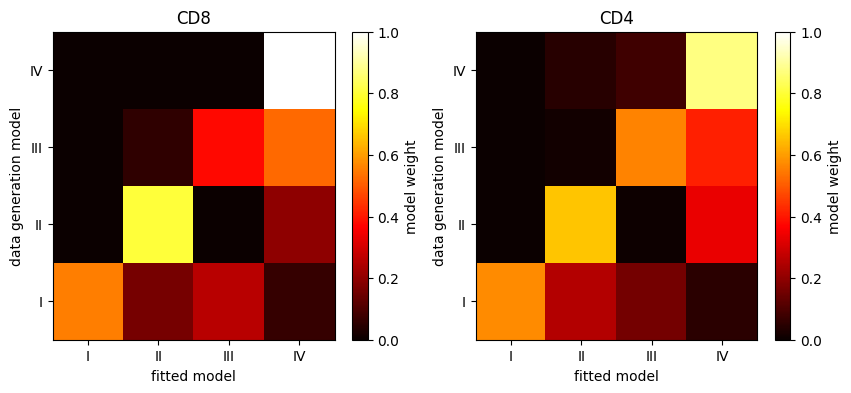

In [8]:
def compute_weight_matrix(lineage, repl):
    loo_results = loo_result_dict[lineage]
    compare_results = {
        gen_model : arviz.compare({k: v[repl] for k, v in loo_results[gen_model].items()}, method="bb-pseudo-bma") for gen_model in models
    }

    # compute matrix with model_weights
    
    weight_matrix = np.zeros((4,4))
    
    for i1, gen_model in enumerate(models):
        comp = compare_results[gen_model]
        weights = comp.weight
        for i2, fit_model in enumerate(models):
            w = weights[fit_model]
            weight_matrix[i1, i2] = w

    return weight_matrix

def compute_med_weight_matrix(lineage):
    weight_mats = [compute_weight_matrix(lineage, repl) for repl in range(replicates)]
    return np.median(weight_mats, axis=0)


weight_matrix_dict = {
    lineage : compute_med_weight_matrix(lineage)
    for lineage in lineages
}

fig, axs = plt.subplots(1, 2, figsize=(10,4))

for ax, lineage in zip(axs, lineages):
    weight_matrix = weight_matrix_dict[lineage]
    C = ax.pcolor(weight_matrix, cmap='hot', vmin=0, vmax=1)
    cs = fig.colorbar(C)
    cs.set_label("model weight")
    
    ax.set_xlabel("fitted model")
    ax.set_ylabel("data generation model")
    
    ticks = np.linspace(0,3,4) + 0.5
    labs = ["I", "II", "III", "IV"]
    ax.set(xticks=ticks, yticks=ticks)
    ax.set(xticklabels=labs, yticklabels=labs)
    ax.set_title(lineage)



## Make plots of simulations and model fits

Check that the fits look OK. First select a lineage and one of the replicates...

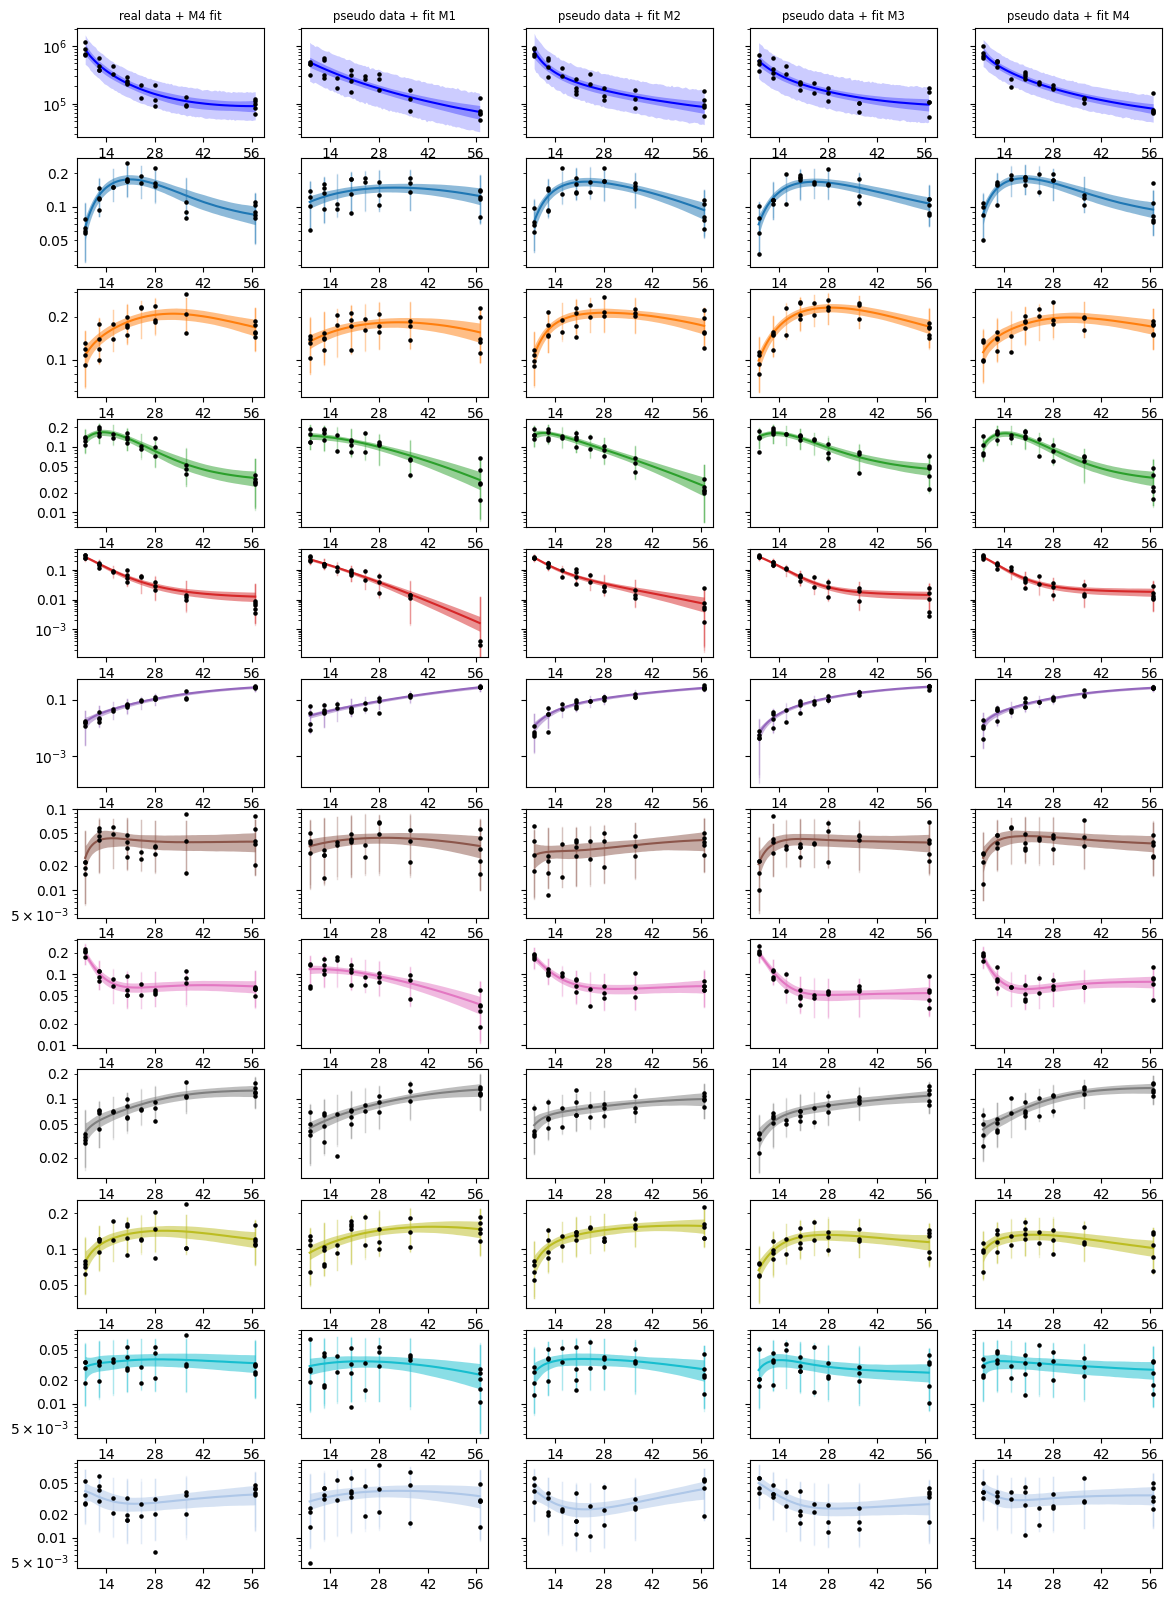

In [9]:
## SELECT LINEAGE AND REPLICATE TO PLOT

lineage = "CD4"
repl = 0


## create the figure

num_pops = len(datasets[lineage]['celltype_names'])

fig, axs = plt.subplots(num_pops+1,5, figsize=(14,20), sharey='row')

# plot real data and model 4 fit (or choose another model)

fit_results = datasets[lineage]["fit_results"]
count_scaling = datasets[lineage]["count_scaling"]
stan_fit, _, stan_data, _ = fit_results["M4"]

plots.plot_stan_fits_fancy(
    axs[0,0],
    axs[1:,0],
    stan_fit, stan_data,
    count_scaling,
    celltype_colors,
    minor_thresholds=(1.8, 0.5)
)

# plot simulated data and fits

pseudo_fit_results = pseudo_fit_result_dict[lineage]

for i, model in enumerate(models):
    stan_fit, _, stan_data, _ = pseudo_fit_results[model][model][repl]
    plots.plot_stan_fits_fancy(
        axs[0,i+1],
        axs[1:,i+1],
        stan_fit, stan_data,
        count_scaling,
        celltype_colors,
        minor_thresholds=(1.8, 0.5)
    )


axs[0,0].set_title("real data + M4 fit", fontsize='small')

for i, model in enumerate(models):
    axs[0, i+1].set_title(f"pseudo data + fit {model}", fontsize='small')

## Export data for identifiability figure

The figure is created in the `FigureIdentifiability.ipynb` notebook.

In [10]:
model_ident_data_dict = {
    "weight_matrix_dict" : weight_matrix_dict,
}

with open("../results/data_figure_model_ident.pkl", 'wb') as f:
    pickle.dump(model_ident_data_dict, f)